In [4]:
import Pkg
using Cxx
using Libdl
using FFTW
using PyPlot

In [5]:
pw = pwd() * "/../src/"
Libdl.dlopen(pw * "liblemur", Libdl.RTLD_GLOBAL)
cxxinclude(pw * "lemur.h")

In [6]:
function set_lemur(maker, nm, var)
    if length(var) > 1
        var = vec(var)
        x = convert(cxxt"double *",pointer(var));
        @cxx maker -> set(pointer(nm), x, length(var))
        
    else
        x = convert(cxxt"double",var);
        try
            @cxx maker -> set(pointer(nm), x)
        catch
            print(string("invalid param", nm))
        end
    end
    return

end

function get_lemur(maker, nm, ny, nx)
    y = @cxx maker -> get(pointer(nm))
    z = unsafe_wrap(Array,pointer(y),ny*nx)
    z = reshape(z,ny,nx)
    return z
end

function isoflex(ero; Te=30e3,dy=100,dx=100, 
    E = 100e9, g = 9.81, v = .25, pm = 3300, 
    bufferx = 0, buffery = 0, pc = 2750,buffer = 0)
    pw = 00;# water density
    m,n = size(ero);
    D = E*(Te)^3/(12*(1-v^2));
    Ly = m * dy;
    Lx = n * dx;
    if mod(n,2) == 1
        bufferx = bufferx+1;
    end
    if mod(m,2) == 1
        buffery = buffery+1;
    end
    
    appndl = zeros(m,buffer+bufferx);
    for i = 1:buffer +bufferx
       appndl[:,i] =  ero[:,1];
    end
    appndr = zeros(m,buffer);
    for i = 1:buffer 
        appndr[:,i] =  ero[:,end];
    end
    ero = [appndl ero appndr];
    appndu = zeros(buffer+buffery,n+2*buffer +bufferx);
    for i = 1:buffer+buffery
        appndu[i,:] =  ero[1,:];
    end
    appndd = zeros(buffer,n+2*buffer+bufferx);
    for i = 1:buffer
        appndd[i,:] =  ero[end,:];
    end
    ero = [appndu; ero; appndd];
    h = fft(ero);
    m,n = size(ero);
    k = zeros(Int(m/2+1),Int(n/2+1));
    k[1,1] = pc/(pm-pw);#(1+(D/(g*(pm-pc))*(2*pi*(1)/(Ly)).^4));
    for i = 2:Int(ceil((m-1)/2)+1)
          k[i,1] =  ((pc)/(pm-pw))*1/(1+(D/(g*(pm-pw))*(2*pi*(i-1)/(Ly)).^4));
    end
    for j = 2:Int(ceil((n-1)/2) + 1)
          k[1,j] = (((pc)/(pm-pw))*1/(1+(D/(g*(pm-pw))*(2*pi*(j-1)/(Lx)).^4)));
    end
    for i = 2:Int(ceil((m-1)/2)+1)
        for j = 2:Int(ceil((n-1)/2)+1)
            k[i,j] = (((pc)/(pm-pw)).*1/(1+(D/(g*(pm-pw))*(2*pi*sqrt(((i-1)/(Ly))^2+((j-1)/(Lx))^2)).^4)));
        end
    end
    k = [k  reverse(k[:,2:end-1],dims = 2)];
    k = [k; reverse(k[2:end-1,:],dims = 1)];
    w = k .* h;
    w = real(ifft(w));
    w = w[buffer+1:end-buffer-bufferx,buffer+1:end-buffer-buffery];
    return w
end

isoflex (generic function with 1 method)

In [7]:
mutable struct lemur_obj
    k
    undercapacity
    z
    dx
    dy
    t
    dt
    display
    Udt
    flex
    kd
    m
    n
    bc
    wdt
    firstcall
    u
    udt
    ny
    nx
    deposit
    srho
    drawdt
    l
    ks
    sinkfill
    uselandsed
    maxareasinkfill
    precip
    evaprate
    k_sed
    lemur_obj() = new()
    
end

In [8]:
lemur_params = lemur_obj()

lemur_obj(#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [20]:
lemur_params.ny = 500
lemur_params.nx = 500
lemur_params.z = rand(lemur_params.ny,lemur_params.nx);
lemur_params.display = 1
lemur_params.udt = 100000
lemur_params.flex = 20e3
lemur_params.deposit = false
lemur_params.bc = zeros(lemur_params.ny,lemur_params.nx)
lemur_params.bc[:, 1] .= 0
lemur_params.bc[:, end] .= 0
lemur_params.bc[1, :] .= 1
lemur_params.bc[end, :] .= 0
bcx = lemur_params.bc
lemur_params.z[lemur_params.bc .== 1] .= 0
lemur_params.bc = vec(lemur_params.bc)
lemur_params.k_sed = 1e-6
lemur_params.srho = 2400
lemur_params.udt = 1e5
lemur_params.bc = float(findall(lemur_params.bc .== 1))
lemur_params.k = zeros(lemur_params.ny,lemur_params.nx) .+ 1e-5
lemur_params.firstcall = 1
lemur_params.l = 1
lemur_params.evaprate = 1e-30
lemur_params.maxareasinkfill = 1000000
lemur_params.precip = 1
lemur_params.kd = 1
lemur_params.ks = 0
lemur_params.dt = 2e5
lemur_params.t = 1e6
lemur_params.undercapacity = zeros(lemur_params.ny,lemur_params.nx)
lemur_params.k_sed = lemur_params.k
lemur_params.flex = 20e3
lemur_params.dx = 1000
lemur_params.dy = 1000
lemur_params.m = .5
lemur_params.n = 1
lemur_params.u = 100000

100000

In [21]:
model = @cxxnew lemur(lemur_params.ny,lemur_params.nx)
for nm = fieldnames(lemur_obj)
    print(string(nm,' '))
    try
        set_lemur(model, string(nm), getfield(lemur_params,nm))
    catch
        print(" error ")
    end
end

k undercapacity z dx dy t dt display Udt  error flex kd m n bc wdt  error firstcall u udt ny nx deposit srho drawdt  error l ks sinkfill  error uselandsed  error maxareasinkfill precip evaprate k_sed t: parameter not founddisplay: parameter not foundflex: parameter not found1u: parameter not foundudt: parameter not foundny: parameter not foundnx: parameter not founddeposit: parameter not foundsrho: parameter not foundk_sed: parameter not found

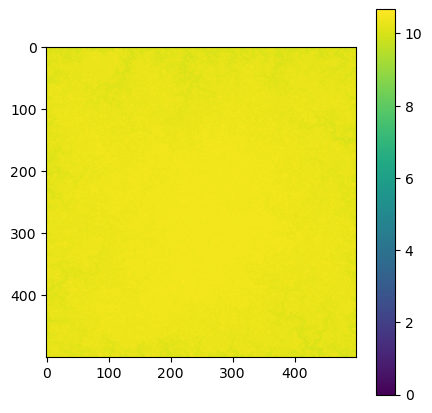

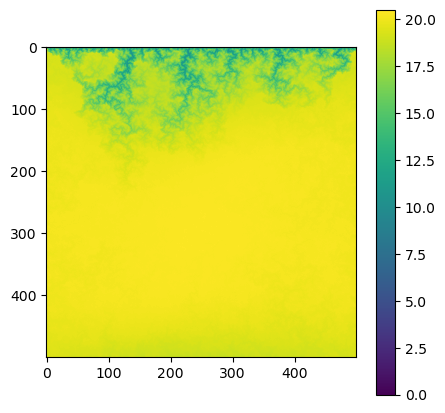

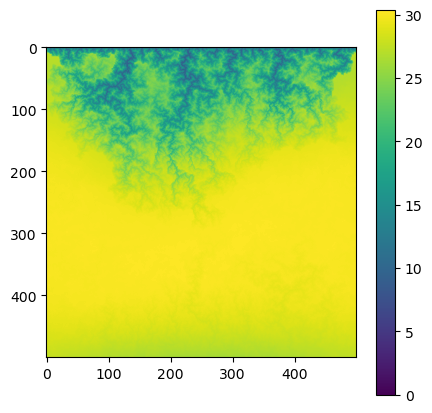

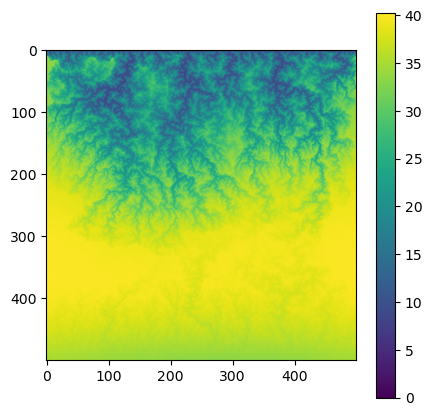

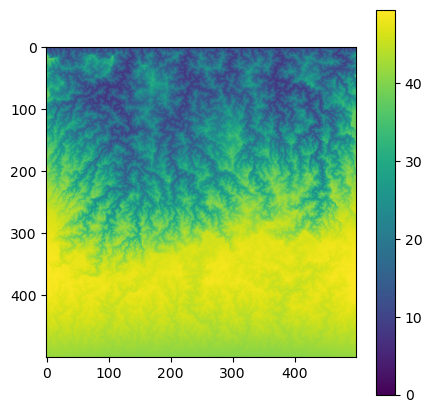

z27514
0
z744
0
z1487
0
z1042
0
z436
0
z

In [22]:
z = get_lemur(model, "z", lemur_params.ny, lemur_params.nx)
zi = zeros(size(z))
flex = zeros(size(z))
ero = zeros(size(z))

for i =lemur_params.dt:lemur_params.dt:lemur_params.t
    @cxx model -> lakefill()
    @cxx model -> erosion_fluvial()
    zi[:] = z[:]
    z[:] =  get_lemur(model, "z", lemur_params.ny, lemur_params.nx)
    ero[:] = z .- zi
    z[bcx .== 0] .+= 10
    flex[:] = isoflex(ero,dx=lemur_params.dx,dy=lemur_params.dy,Te=lemur_params.flex)
    z[bcx .== 0] .+= flex[bcx .== 0]
    set_lemur(model,"z", vec(z))
    subplots(figsize=[5,5])
    imshow(z)
    colorbar()
    
end

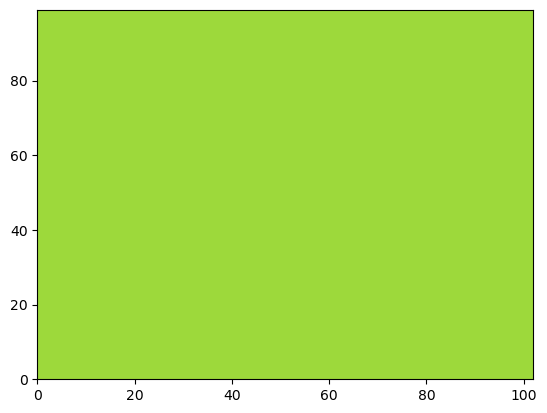

PyObject <matplotlib.collections.PolyCollection object at 0x7fc6aa96b250>

In [339]:
pcolor(isoflex(rand(100,101)),vmin=.2,vmax=.45)